In [2]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d
from pydd.analysis import calculate_SNR, calculate_match_unnormd_fft, get_match_pads, loglikelihood_fft, loglikelihood_fft_data, calculate_match_unnormd_fft_data
from pydd.binary import (
    AccretionDisk,
    MSUN,
    PC,
    Phi_to_c,
    get_c_f,
    _Phi_to_c_indef,
    VacuumBinary,
    convert,
    get_M_chirp,
    get_f_isco,
    get_f_range,
    get_m_1,
    make_vacuum_binary,
    t_to_c,
    YR,
    amp,
    d2Phi_dt2,
    G,
    C,
    Psi,
    restricted_hypgeom,
    h_0,
    _Phi_to_c_indef
)

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange

/Users/pippacole/Dropbox/Mac/Documents/pydd-pip/src/pydd/binary.py:535: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [3]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "18"

In [4]:
# Set detector
detector = "LISA"

In [5]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #seconds
    SNR_THRESH = 100.0
    TITLE = "LISA"

# Create fiducial template

In [18]:
def get_signal_system() -> Tuple[AccretionDisk, Tuple[float, float]]:
    """
    Creates an accretion disk with SNR and duration as set above for given detector.
    
    """
    M_1 = np.array(1e5 * MSUN) # kg
    M_2 = np.array(10 * MSUN) # kg
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    sigM2 = 1.58e10 # Sigma_0 * Mach^2 in kg/m^2
    TT_C = np.array(0.0) # time of coalescence
    F_C = get_f_isco(M_1)
    PHI_C = np.array(0.0) # phase at coalescence
    PN = 0 # zero means don't include PN effects
    _AD_D = AccretionDisk(PN,
        sigM2,
        -1, # torques act to speed up inspiral (choose 1 for opposite direction)
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=np.array(100e6 * PC), # luminosity distance to source in metres, dummy fixed here
        f_c=get_f_isco(M_1),
    )

    # Frequency range and grids
    F_RANGE_D = get_f_range(_AD_D, T_OBS)
    FS = np.linspace(
        max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000
    )

    # Get dL such that SNR is as set above
    _fn = lambda dL: calculate_SNR(
            AccretionDisk(_AD_D.PN,
                _AD_D.SigM2,
                _AD_D.inout,
                _AD_D.M_chirp,
                _AD_D.q,
                _AD_D.Phi_c,
                _AD_D.tT_c,
                dL,
                _AD_D.f_c,
            ),
            FS,
            S_n,
        )
    
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    AD_D = AccretionDisk(_AD_D.PN,
        _AD_D.SigM2,
        _AD_D.inout,
        _AD_D.M_chirp,
        _AD_D.q,
        _AD_D.Phi_c,
        _AD_D.tT_c,
        DL,
        _AD_D.f_c,
    )

    return AD_D, F_RANGE_D

In [22]:
AD_D, F_RANGE_D = get_signal_system()

FS = np.linspace(F_RANGE_D[0], F_RANGE_D[-1], 10_000)  # coarser grid

PAD_LOW, PAD_HIGH = get_match_pads(FS)  # padding for likelihood calculation

In [23]:
def get_frequency_noise(psd, fs):
    
    delta_f = fs[1] - fs[0]
    sigma = np.sqrt(psd(fs)/(4 * delta_f))
    not_zero = (sigma != 0)
    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_co = np.random.normal(0, sigma_red)

    noise_red = (1/np.sqrt(2)) * (noise_re + 1j * noise_co)

    noise = np.zeros(len(sigma), dtype=complex)
    noise[not_zero] = noise_red

    return noise

In [24]:
def waveform(params_h, fs, S_n):
    flen = len(fs)
    delta_f = fs[1] - fs[0]
    
    wf_h = amp(fs, params_h) * np.exp(1j * Psi(fs, params_h))
    noise = get_frequency_noise(S_n, fs)
    
    wf_h_noise = wf_h + noise
    
    return wf_h, noise, wf_h_noise

# Generate 'observation' (waveform + noise) either with above, or pull in data from elsewhere

In [124]:
with open("file_name", "rb") as f:
    obs = pickle.load(f)

In [ ]:
F_OBS = # pull in frequency grid from observation

In [ ]:
SIG_OBS = # pull in h (averaged over inclination angle) from observation

In [25]:
#signal = SIG_OBS 
signal = waveform(AD_D, FS, S_n)[2] # use this if you want to use a noisy analytical template as your observation instead

# Functions for likelihood calculation

In [32]:
def calculate_SNR(params, fs, S_n=S_n):
    integrand = amp(fs, params) ** 2 / S_n(fs)
    return np.sqrt(4 * np.trapz(integrand, fs))

def calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[1] - fs[0]
    wf_h = amp(fs, params_h) * np.exp(1j * Psi(fs, params_h)) # h is the model/template
    wf_d = signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = calculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

# Check 'max' likelihood 

In [33]:
maxll = loglikelihood_fft(AD_D, AD_D, FS, PAD_LOW, PAD_HIGH)
print(maxll)

4942.4366012878


# Set up prior to sample from

In [34]:
# symmetric priors around true value

true_value = [AD_D.M_chirp]

M_prior = 5e-1 * MSUN

prior_list = [M_prior]

In [42]:
# uniform log priors

def ptform_log(u: np.ndarray, param_index) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (1,)
    v_m = np.array([np.log10((true_value[param_index] + prior_list[param_index]) / (true_value[param_index] - prior_list[param_index]))])
    return [v_m[0] * (u[0])]


def unpack(x: np.ndarray, param_index) -> AccretionDisk:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    
    sample_param = np.zeros(1)
    sample_param[param_index] = x[0]
    
    choose_prior = np.zeros(1)
    choose_prior[param_index] = prior_list[param_index]

    Mc = (AD_D.M_chirp - choose_prior[0]) * 10**sample_param[0]
    q = AD_D.q
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    PN = 0

    return AccretionDisk(PN, AD_D.SigM2, -1, Mc, AD_D.q, AD_D.Phi_c, AD_D.tT_c, AD_D.dL, f_c)

def get_ll_fft(x: np.ndarray, param_index) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack(x, param_index)
    return loglikelihood_fft(ad_h, AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [36]:
# uniform priors, don't run both this and log priors

def ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (1,)
    v_m = np.array([3000])
    return [2 * v_m[0] * (u[0]-0.5)]


def unpack(x: np.ndarray) -> AccretionDisk:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    dMc = x[0]
    Mc = AD_D.M_chirp + dMc * MSUN
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    PN = 0
    
    return AccretionDisk(PN, AD_D.SigM2, -1, Mc, AD_D.q, AD_D.Phi_c, AD_D.tT_c, AD_D.dL, f_c)

def get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack(x)
    return loglikelihood_fft(ad_h, AD_D, FS, PAD_LOW, PAD_HIGH, S_n)
"""

# Sample points and compute likelihood

In [43]:
mass = 0 # M_chirp

# choose which parameter

param = mass

if param == mass:
    units = MSUN
else: units = 1

In [45]:
xs_log = []
lls_log = []
for _ in trange(10000):
    xs_log.append(ptform_log(np.random.rand(1), param))
    lls_log.append(get_ll_fft(xs_log[-1], param))

xs_log = np.array(xs_log)
lls_log = np.array(lls_log)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [60]:
#xs = []
#lls = []
#for _ in trange(1000):
#    xs.append(ptform(np.random.rand(1)))
#    lls.append(get_ll_fft(xs[-1]))
               
#xs = np.array(xs)
#lls = np.array(lls)

  0%|          | 0/1000 [00:00<?, ?it/s]

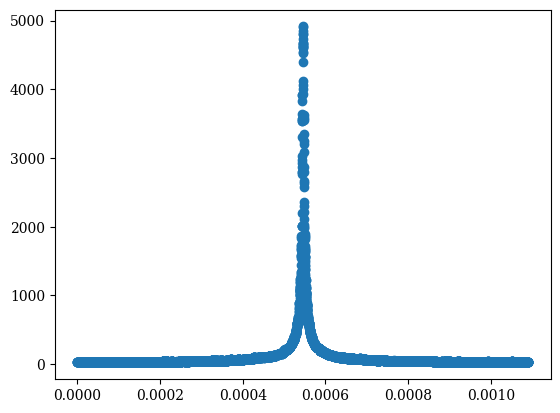

In [46]:
plt.scatter(xs_log,lls_log)

# Nested Sampling

In [ ]:
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform_log, 1, nlive=1000, bound = 'single')
sampler.run_nested(dlogz = 10) # dlogz is the threshold on the change in evidence that stops the run
results_1d = sampler.results

In [ ]:
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]"
)
 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    results_1d, labels=labels, quantiles_2d=quantiles_2d, truths=(0), verbose = True, span = [(-1,1)]
)
fig.tight_layout()